# **Twitter Sentiment Analysis with Supervised Learning**

1. Initial data transformation
2. Simple visualization
3. Logistic Regression model

In [19]:
# 필요한 라이브러리를 import하세요.
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **1. 데이터 불러오기**

* twitter_training 데이터는 train으로, twitter_validation 데이터는 val로 불러오세요.
  * `header=None` 옵션으로 불러오세요.

In [4]:
# 드라이브 마운트(선택 사항)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train=pd.read_csv("/content/drive/MyDrive/twitter_training.csv", header=None)
val=pd.read_csv("/content/drive/MyDrive/twitter_validation.csv", header=None)

In [6]:
train.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
val.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## **2. 전처리**
* train은 훈련 데이터셋, val은 검증 데이터셋입니다.
* 각 열의 이름을 id, information, type, text로 설정해주세요.

In [8]:
train.columns = ['id', 'information', 'type', 'text']
val.columns = ['id', 'information', 'type', 'text']

In [9]:
train.head()

,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [10]:
val.head()

,id,information,type,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [11]:
# train 데이터와 val 데이터의 text 열을 소문자로 바꾸고, NaN 값은 공백으로 대체하는 코드를 작성하세요.
train['text'] = train['text'].str.lower().fillna('')
val['text'] = val['text'].str.lower().fillna('')

In [13]:
# train 데이터와 val 데이터의 text 열 중 영어 문자열이 아닌 문자는 모두 공백으로 변환하는 코드를 작성하세요.
train['text'] = train['text'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
val['text'] = val['text'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

## **3. 시각화**
* information(각 브랜드) 별 type의 개수를 보여주는 막대 그래프를 그리세요.
  * x축에는 Brand가, y축에는 Number of tweets가 오도록하고, x축명, y축명을 각각 'Brand', 'Number of tweets'로 설정해주세요.
  * type별로 막대 색이 다르게 나올 수 있도록 설정해주세요.
  * 제안 : groupby를 사용하여 데이터프레임을 만든 후 시각화하셔도 됩니다.

In [14]:
plot1 = train.groupby(by=["information", "type"]).count().reset_index()
plot1.head()

,information,type,id,text
0,Amazon,Irrelevant,192,192
1,Amazon,Negative,576,576
2,Amazon,Neutral,1236,1236
3,Amazon,Positive,312,312
4,ApexLegends,Irrelevant,192,192


Text(0.5, 1.0, 'Distribution of tweets per Branch and Type')

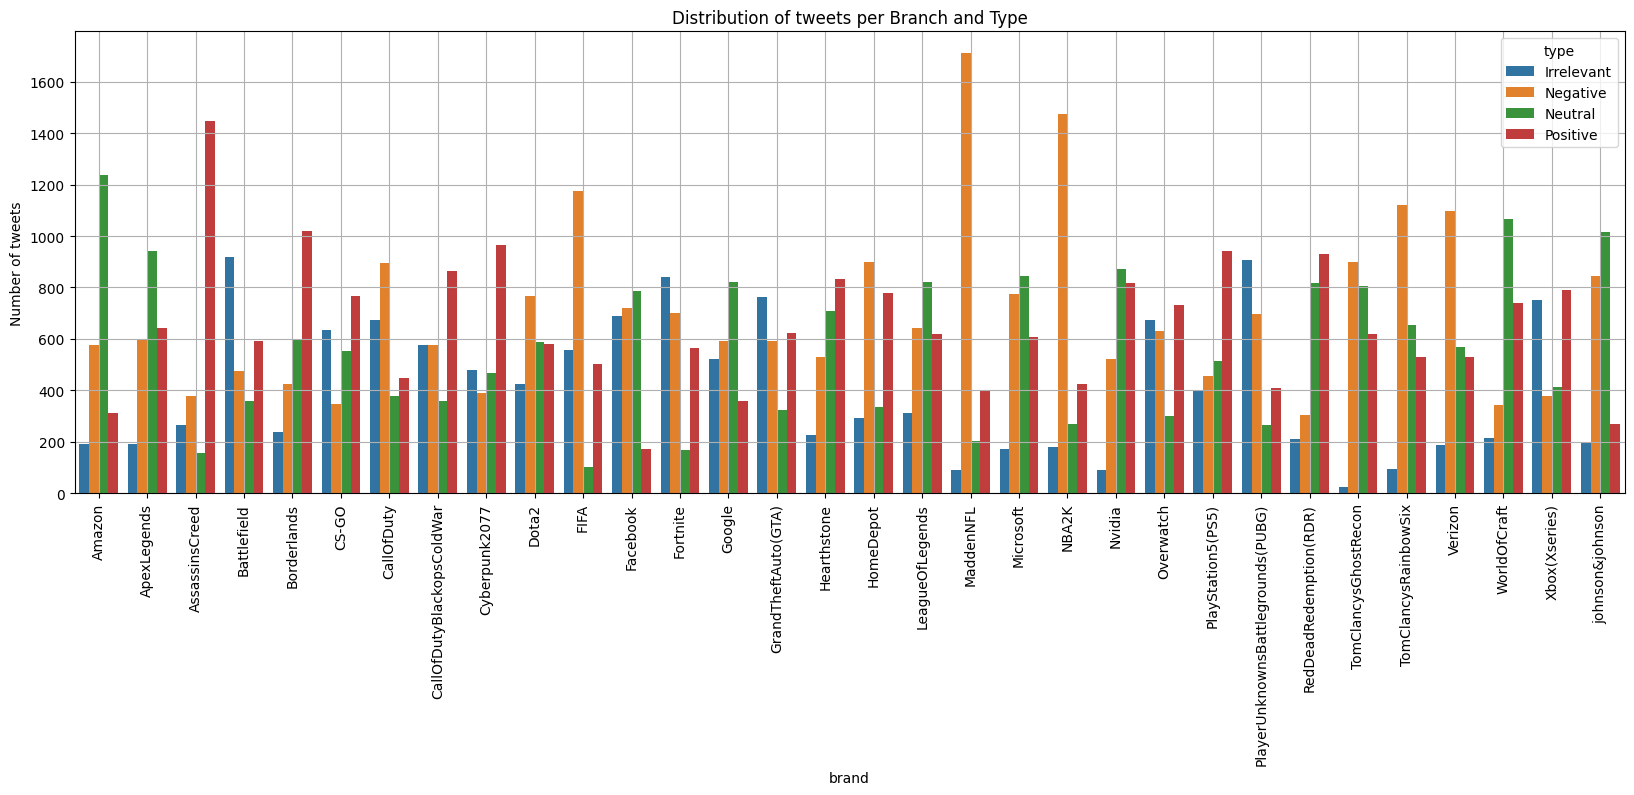

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,6))
sns.barplot(data=plot1, x='information', y='id', hue='type')
plt.xticks(rotation=90)
plt.xlabel("brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type")

## **4. 피처 벡터화 변환과 머신러닝 모델 학습/예측/평가**
* Count 벡터화를 적용해 예측 성능을 측정해보세요.
    * Classifier는 LogisticRegression을 이용합니다.
    * 예측 성능 평가는 다중 분류임을 고려해 정확도, F1 score, 혼동행렬을 모두 측정합니다. Classification Report를 출력해도 무방합니다.
    * `tokenizer=word_tokenize, stop_words='english', ngram_range=(1, 1)`으로 지정해주세요.
    * 파이프라인 객체를 이용하는 것은 선택 사항입니다.

In [20]:
pipeline = Pipeline([
        ('cnt_vect', CountVectorizer(
            tokenizer=word_tokenize,
            stop_words='english',
            ngram_range=(1, 1))),
        ('lr_clf', LogisticRegression(C=0.9, solver="liblinear", max_iter=1500))
])

# Train 데이터로 학습
pipeline.fit(train['text'], train['type'])

# Validation 데이터로 예측
y_val_pred = pipeline.predict(val['text'])
accuracy = accuracy_score(val['type'], y_val_pred)

# 평가 결과 출력
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", confusion_matrix(val['type'], y_val_pred))
print("Classification Report:\n", classification_report(val['type'], y_val_pred))

Validation Accuracy: 93.70%
Confusion Matrix:
 [[157   5   1   9]
 [  1 254   2   9]
 [  2  10 265   8]
 [  4   5   7 261]]
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.96      0.91      0.93       172
    Negative       0.93      0.95      0.94       266
     Neutral       0.96      0.93      0.95       285
    Positive       0.91      0.94      0.93       277

    accuracy                           0.94      1000
   macro avg       0.94      0.93      0.94      1000
weighted avg       0.94      0.94      0.94      1000



* TF-IDF 벡터화를 적용해 예측 성능을 측정해 보세요.
    * Classifier는 LogisticRegression을 이용합니다.
    * 예측 성능 평가는 다중 분류임을 고려해 정확도, F1 score, 혼동행렬을 모두 측정합니다. Classification Report를 출력해도 무방합니다.
    * `stop_words='english', ngram_range=(1, 2)`으로 지정해주세요.
    * 파이프라인 객체를 이용하는 것은 선택 사항입니다.


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
     ('lr_clf', LogisticRegression(solver='liblinear', C=10))
     ])

# Train 데이터로 학습
pipeline.fit(train['text'], train['type'])

# Validation 데이터로 예측
y_val_pred = pipeline.predict(val['text'])
accuracy = accuracy_score(val['type'], y_val_pred)

# 평가 결과 출력
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", confusion_matrix(val['type'], y_val_pred))
print("Classification Report:\n", classification_report(val['type'], y_val_pred))

Validation Accuracy: 98.40%
Confusion Matrix:
 [[170   1   0   1]
 [  1 261   2   2]
 [  0   0 281   4]
 [  2   1   2 272]]
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.98      0.99      0.99       172
    Negative       0.99      0.98      0.99       266
     Neutral       0.99      0.99      0.99       285
    Positive       0.97      0.98      0.98       277

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



## **5. 최적화** (보너스 문제)

파라미터를 조절하여 가장 높은 정확도를 가지는 모델을 만들고, 조원들과 공유해보세요.

* 제안
    * CountVectorizer, TfidfVectorizer에서는 `stop_words, ngram_range` 조절
    * LogisticRegression에서는 `C, max_iter` 조절